### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

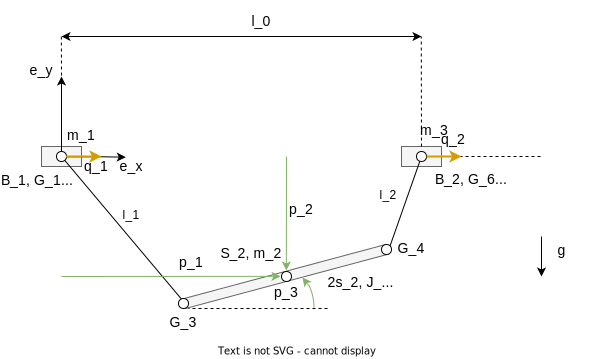

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

aa.T := [a₁  a₂  a₃  a₄]

---

ttheta.T := [p₁  p₂  p₃  q₁  q₂]

---

tthetad.T := [ṗ₁  ṗ₂  ṗ₃  q̇₁  q̇₂]

---

tthetadd.T := [p̈₁  p̈₂  p̈₃  q̈₁  q̈₂]

---

tthetaddd.T := [p⃛₁  p⃛₂  p⃛₃  q⃛₁  q⃛₂]

---

tthetadddd.T := [p⃜₁  p⃜₂  p⃜₃  q⃜₁  q⃜₂]

---

QQ.T := [Q₁  Q₂  Q₃  Q₄  Q₅]

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")


Specify the geometry (joints G and centers of masses S)

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# suspension points of load
G3 = S2 - Rz(p3)*ex*s2 ##:
G4 = S2 + Rz(p3)*ex*s2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

B1 := ⎡q₁⎤
⎢  ⎥
⎣0 ⎦

---

B2 := ⎡l₀ + q₂⎤
⎢       ⎥
⎣   0   ⎦

---

G3 := ⎡p₁ - s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ - s₂⋅sin(p₃)⎦

---

G4 := ⎡p₁ + s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ + s₂⋅sin(p₃)⎦

---

(Sd1, Sd2, Sd3) := ⎛⎡q̇₁⎤  ⎡ṗ₁⎤  ⎡q̇₂⎤⎞
⎜⎢  ⎥, ⎢  ⎥, ⎢  ⎥⎟
⎝⎣0 ⎦  ⎣ṗ₂⎦  ⎣0 ⎦⎠

---

this model is very easy ...

In [6]:
F1 = sp.Matrix([tau1, 0])  ##:T
F2 = sp.Matrix([tau2, 0])  ##:T

# unit vectors for ropes to split forces according to angles
rope1 = (G3 - S1)
rope2 = (G4 - S3)
uv_rope1 = rope1/sp.sqrt((rope1.T*rope1)[0])
uv_rope2 = rope2/sp.sqrt((rope2.T*rope2)[0])

# simplify expressions by using l1, l2 as shortcuts 
uv_rope1 = rope1/l1
uv_rope2 = rope2/l2

F3 = uv_rope1 * tau3 ##:
F4 = uv_rope2 * tau4 ##:

F1.T := [τ₁  0]

---

F2.T := [τ₂  0]

---

F3 := ⎡τ₃⋅(p₁ - q₁ - s₂⋅cos(p₃))⎤
⎢─────────────────────────⎥
⎢            l₁           ⎥
⎢                         ⎥
⎢  τ₃⋅(p₂ - s₂⋅sin(p₃))   ⎥
⎢  ────────────────────   ⎥
⎣           l₁            ⎦

---

F4 := ⎡τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⎤
⎢───────────────────────────────⎥
⎢               l₂              ⎥
⎢                               ⎥
⎢     τ₄⋅(p₂ + s₂⋅sin(p₃))      ⎥
⎢     ────────────────────      ⎥
⎣              l₂               ⎦

---

#### Quasistatic state feedback control

In [48]:
# load model etc. from pickle of flatness analysis notebook
with open("flatness_analysis_control.pcl", "rb") as pfile:
    mod, eqns, ttau, flat_q2, flat_qddot2, flat_tau1, flat_tau2, flat_tau3, flat_tau4, flat_tau1_control, flat_tau2_control, flat_tau3_control, flat_tau4_control = pickle.load(pfile)

In [49]:
flat_tau1.s ##:
flat_tau2.s ##:
flat_tau3.s ##:
flat_tau4.s ##:

---

---

---

---

Nonlinearities are chosen to be the new inputs of the system:
\begin{align}
    v_1 &:= p_1^{(4)} = y_1^{(4)} \\
    v_2 &:= p_2^{(4)} = y_2^{(4)} \\
    v_3 &:= p_3^{(4)} = y_3^{(4)} \\
    v_4 &:= \ddot{q}_1 = \ddot{y}_4 
\end{align}

In [50]:
ttaud = st.time_deriv(ttau, ttau)
ttaudd = st.time_deriv(ttau, ttau, order=2)

st.make_global(ttaud, ttaudd)

In [51]:
# combined vector field
fg = mod.state_eq

In [52]:
y1 = mod.xx[0]
yd1 = st.lie_deriv(y1, fg, mod.xx, order=1)
ydd1 = st.lie_deriv(y1, fg, mod.xx, order=2)
yddd1 = st.lie_deriv(y1, fg, mod.xx, order=3) + ydd1.subz([tau3, tau4], [taudot3, taudot4])

jac_1_3 = st.jac(yddd1, ttau).smplf
jac_1_4 = st.jac(yddd1, ttaud).smplf

ydddd1 = st.lie_deriv(yddd1, fg, mod.xx) + (jac_1_3*ttaud)[0] + (jac_1_4*ttaudd)[0]

yd1.s ##:
ydd1.s ##:
yddd1.s ##:
ydddd1.s ##:

---

---

---

---

In [53]:
y2 = mod.xx[1]
yd2 = st.lie_deriv(y2, fg, mod.xx, order=1)
ydd2 = st.lie_deriv(y2, fg, mod.xx, order=2)
yddd2 = st.lie_deriv(y2, fg, mod.xx, order=3) + ydd2.subz([tau3, tau4], [taudot3, taudot4])

jac_2_3 = st.jac(yddd2, ttau).smplf
jac_2_4 = st.jac(yddd2, ttaud).smplf

ydddd2 = st.lie_deriv(yddd2, fg, mod.xx) + (jac_2_3*ttaud)[0] + (jac_2_4*ttaudd)[0]

yd2.s ##:
ydd2.s ##:
yddd2.s ##:
ydddd2.s ##:

---

---

---

---

In [54]:
y3 = mod.xx[2]
yd3 = st.lie_deriv(y3, fg, mod.xx, order=1)
ydd3 = st.lie_deriv(y3, fg, mod.xx, order=2)
yddd3 = st.lie_deriv(y3, fg, mod.xx, order=3) + ydd3.subz([tau3, tau4], [taudot3, taudot4])

jac_3_3 = st.jac(yddd3, ttau).smplf
jac_3_4 = st.jac(yddd3, ttaud).smplf

ydddd3 = st.lie_deriv(yddd3, fg, mod.xx) + (jac_3_3*ttaud)[0] + (jac_3_4*ttaudd)[0]

yd3.s ##:
ydd3.s ##:
yddd3.s ##:
ydddd3.s ##:

---

---

---

---

In [55]:
y4 = mod.xx[3]
yd4 = st.lie_deriv(y4, fg, mod.xx, order=1)
ydd4 = st.lie_deriv(y4, fg, mod.xx, order=2)
yddd4 = st.lie_deriv(y4, fg, mod.xx, order=3) + ydd4.subz([tau3, tau4], [taudot3, taudot4])

jac_4_3 = st.jac(yddd4, ttau).smplf
jac_4_4 = st.jac(yddd4, ttaud).smplf

ydddd4 = st.lie_deriv(yddd4, fg, mod.xx) + (jac_4_3*ttaud)[0] + (jac_4_4*ttaudd)[0]

yd4.s ##:
ydd4.s ##:
yddd4.s ##:
ydddd4.s ##:

---

---

---

---

#### Inputs from flat output

In [95]:
sol_tau134 = sp.solve((pddot1-ydd1, pddot3-ydd3, qddot1-ydd4), tau1, tau3, tau4)
tau1_alg = sol_tau134[tau1].smplf
tau3_alg = sol_tau134[tau3].smplf
tau4_alg = sol_tau134[tau4].smplf

In [115]:
# TODO: Is it legit to use mod.f instead of fg ???
taudot3_alg = st.lie_deriv(tau3_alg, mod.f, mod.xx, order=1)
tauddot3_alg = st.lie_deriv(taudot3_alg, mod.f, mod.xx, order=1)
taudot4_alg = st.lie_deriv(tau4_alg, mod.f, mod.xx, order=1)
tauddot4_alg = st.lie_deriv(taudot4_alg, mod.f, mod.xx, order=1)

In [128]:
ydddd2.subz([tau1, tau3, tau4, taudot3, taudot4, tauddot3, tauddot4], [tau1_alg, tau3_alg, tau4_alg, taudot3_alg, taudot4_alg, tauddot3_alg, tauddot4_alg]).co

In [125]:
#TODO: takes too long 
sol_tau2 = sp.solve(ydddd2.subz([tau1, tau3, tau4, taudot3, taudot4, tauddot3, tauddot4], [tau1_alg, tau3_alg, tau4_alg, taudot3_alg, taudot4_alg, tauddot3_alg, tauddot4_alg])-pddddot2, tau2)

KeyboardInterrupt: 